In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('all-star-dataset.csv')
df = df.dropna(subset=['player'])

EDA

In [3]:
print("Head of the dataset:")
print(df.head(), "\n")

print("Dataset info:")
print(df.info(), "\n")

print("Summary statistics:")
print(df.describe(), "\n")

df.fillna(df.select_dtypes(include=[np.number]).median(), inplace=True)

Head of the dataset:
   season          player   g    gs      mp   fg   fga  x3p  x3pa  x2p  ...  \
0    1982  Adrian Dantley  81  81.0  3222.0  904  1586  1.0   3.0  903  ...   
1    1982         Al Wood  96  10.0  1860.0  358   762  6.0  48.0  352  ...   
2    1982      Alan Hardy  38   0.0   310.0   62   136  0.0   5.0   62  ...   
3    1982     Albert King  76  52.0  1694.0  391   812  3.0  13.0  388  ...   
4    1982    Alex Bradley  39   0.0   331.0   54   103  0.0   1.0   54  ...   

   fta    orb    drb  ast   stl   blk    tov   pf   pts  all_star  
0  818  231.0  283.0  324  95.0  14.0  299.0  252  2457      True  
1  238  102.0  166.0  116  62.0  18.0  142.0  216   908     False  
2   29   14.0   20.0   20   9.0   4.0   20.0   32   142     False  
3  171  105.0  207.0  142  64.0  36.0  180.0  261   918     False  
4   48   31.0   34.0   11  12.0   5.0   28.0   37   137     False  

[5 rows x 22 columns] 

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18785 e

Explore Features

In [4]:
# Points per minute (handle division by zero)
df['ppm'] = np.where(df['mp'] > 0, df['pts'] / df['mp'], 0)

# Shooting percentages (avoid division by zero)
df['fg_pct']   = np.where(df['fga'] > 0, df['fg'] / df['fga'], 0)
df['x3p_pct']  = np.where(df['x3pa'] > 0, df['x3p'] / df['x3pa'], 0)
df['x2p_pct']  = np.where(df['x2pa'] > 0, df['x2p'] / df['x2pa'], 0)
df['ft_pct']   = np.where(df['fta'] > 0, df['ft'] / df['fta'], 0)

# Assist-to-turnover ratio (if turnovers is 0, assign 0)
df['ast_tov'] = np.where(df['tov'] > 0, df['ast'] / df['tov'], 0)

# Total rebounds as a new feature
df['reb'] = df['orb'] + df['drb']

Feature Selection

In [5]:
features_all_star = df.drop(columns=['player', 'season', 'all_star'])
X_all_star = features_all_star.select_dtypes(include=[np.number])
y_all_star = df['all_star']

# Use a Random Forest classifier to rank feature importance
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_all_star, y_all_star)
importances = clf.feature_importances_
feat_importances = pd.Series(importances, index=X_all_star.columns)
feat_importances = feat_importances.sort_values(ascending=False)
print("Feature importances for predicting All-Star status:")
print(feat_importances, "\n")

Feature importances for predicting All-Star status:
pts        0.102748
ppm        0.093175
ft         0.074955
fg         0.067001
fta        0.059030
g          0.050364
fga        0.038972
mp         0.038781
x2p        0.038037
tov        0.036915
drb        0.035713
ast        0.034891
gs         0.034843
pf         0.034432
ast_tov    0.027389
blk        0.027328
stl        0.025105
x2p_pct    0.024758
reb        0.024200
x2pa       0.023587
fg_pct     0.023096
ft_pct     0.021522
orb        0.019608
x3p_pct    0.016042
x3pa       0.014867
x3p        0.012642
dtype: float64 



Model Selection & Training

In [6]:
# Use engineered features and original stats to predict 'mp' (minutes played)
# Remove identifiers and the all_star indicator from features
features = df.drop(columns=['player', 'season', 'mp', 'all_star'])
target = df['mp']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ----- Linear Regression -----
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# ----- Decision Tree Regressor -----
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train_scaled, y_train)
y_pred_dt = dt.predict(X_test_scaled)

# ----- Random Forest Regressor -----
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

Model Evaluation

In [7]:
def evaluate_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    print(f"{name} - RMSE: {rmse:.2f}, R^2: {r2:.2f}")

print("Model Evaluation on Test Data:")
evaluate_model("Linear Regression", y_test, y_pred_lr)
evaluate_model("Decision Tree", y_test, y_pred_dt)
evaluate_model("Random Forest", y_test, y_pred_rf)
print("\n")

Model Evaluation on Test Data:
Linear Regression - RMSE: 154.29, R^2: 0.98
Decision Tree - RMSE: 124.29, R^2: 0.99
Random Forest - RMSE: 70.49, R^2: 1.00




Analysis

In [8]:
# Use the best performing model (e.g., Random Forest) to predict ideal minutes for all players.
df['predicted_mp'] = rf.predict(scaler.transform(features))
df['difference'] = df['predicted_mp'] - df['mp']

# Identify overutilized players (actual minutes significantly higher than predicted)
overutilized = df.sort_values(by='difference').head(10)
# Identify underutilized players (actual minutes significantly lower than predicted)
underutilized = df.sort_values(by='difference', ascending=False).head(10)

print("Top 10 Overutilized Players (predicted ideal < actual):")
print(overutilized[['player', 'mp', 'predicted_mp', 'difference']], "\n")
print("Top 10 Underutilized Players (predicted ideal > actual):")
print(underutilized[['player', 'mp', 'predicted_mp', 'difference']], "\n")

Top 10 Overutilized Players (predicted ideal < actual):
                  player      mp  predicted_mp  difference
7608           Bo Outlaw  3856.0       2785.57    -1070.43
8126       Desmond Mason  5526.0       4565.58     -960.42
6036    Jerry Stackhouse  5090.0       4277.38     -812.62
11341     Jared Jeffries  3588.0       2834.85     -753.15
9815       Allen Iverson  5522.0       4817.29     -704.71
4980         Bimbo Coles  5230.0       4526.16     -703.84
10455      Jason Collins  2344.0       1775.85     -568.15
11214        Carl Landry  4938.0       4416.38     -521.62
8457   Anfernee Hardaway  4190.0       3673.15     -516.85
5584          Jason Kidd  3928.0       3432.01     -495.99 

Top 10 Underutilized Players (predicted ideal > actual):
                   player      mp  predicted_mp  difference
12850   Marreese Speights  2600.0       3125.23      525.23
14490    Bojan Bogdanović  4166.0       4633.00      467.00
4977      Benoit Benjamin  3792.0       4257.02      465

Visualizing Results

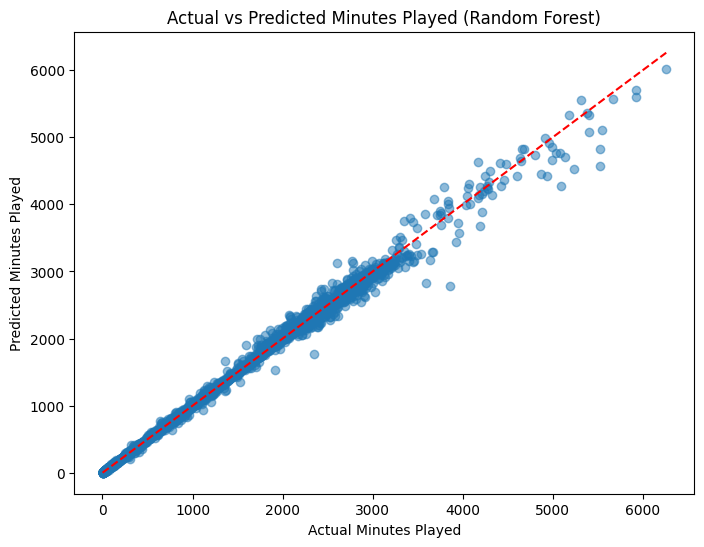

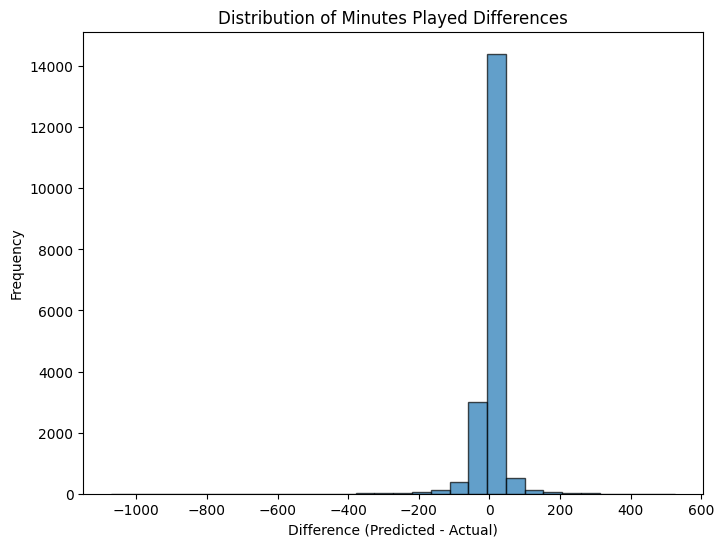

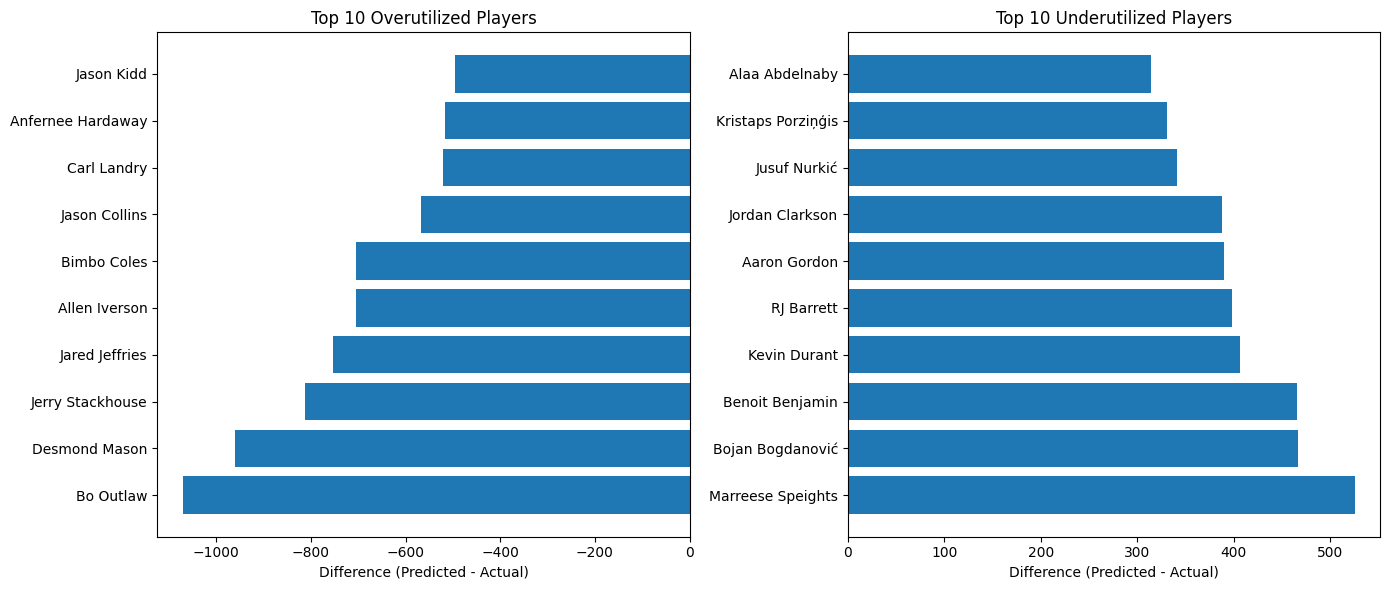

In [9]:
# Scatter plot: Actual vs Predicted Minutes (Random Forest)
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.xlabel("Actual Minutes Played")
plt.ylabel("Predicted Minutes Played")
plt.title("Actual vs Predicted Minutes Played (Random Forest)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

# Histogram of differences
plt.figure(figsize=(8,6))
plt.hist(df['difference'], bins=30, edgecolor='k', alpha=0.7)
plt.xlabel("Difference (Predicted - Actual)")
plt.ylabel("Frequency")
plt.title("Distribution of Minutes Played Differences")
plt.show()

# Bar charts for top overutilized and underutilized players
fig, ax = plt.subplots(1, 2, figsize=(14,6))
ax[0].barh(overutilized['player'], overutilized['difference'])
ax[0].set_title("Top 10 Overutilized Players")
ax[0].set_xlabel("Difference (Predicted - Actual)")
ax[1].barh(underutilized['player'], underutilized['difference'])
ax[1].set_title("Top 10 Underutilized Players")
ax[1].set_xlabel("Difference (Predicted - Actual)")
plt.tight_layout()
plt.show()
